In [39]:
#Business problem: company wants to develop model to detect fraudulent credit card charges
#goal: lower the no of fraudulent transactions and also the no of real transactions flagged as fraud
#build model to predict fraudulent transactions
#Data Exploration and Hypothesis Formation
#Load the dataset and initial exploration:

# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [40]:
# Display the first few rows and basic info
print(data.head())

   Transaction ID  Customer ID  Transaction Amount Transaction Date and Time  \
0               1         4174          659.297095       2023-01-01 00:00:00   
1               2         4507          474.046452       2023-01-01 00:01:00   
2               3         1860          498.819570       2023-01-01 00:02:00   
3               4         2294          744.199592       2023-01-01 00:03:00   
4               5         2130          279.181247       2023-01-01 00:04:00   

  Merchant Category       Location  Previous Transaction Amount  \
0          Clothing    Los Angeles                   579.323704   
1            Dining        Houston                   407.220271   
2            Dining  San Francisco                   265.583605   
3       Electronics    Los Angeles                  1097.259081   
4       Electronics    Los Angeles                   238.389682   

   Time Since Last Transaction Device Type Fraud  
0                   481.377516     desktop    No  
1             

In [41]:

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB
None


In [42]:
#descriptive statistics
print(data.describe())

       Transaction ID   Customer ID  Transaction Amount  \
count     10000.00000  10000.000000        10000.000000   
mean       5000.50000   3010.561100          559.865608   
std        2886.89568   1152.371939          399.984400   
min           1.00000   1000.000000            1.000000   
25%        2500.75000   2001.750000          262.969956   
50%        5000.50000   3004.000000          522.370941   
75%        7500.25000   4010.000000          788.415931   
max       10000.00000   4999.000000         2953.394492   

       Previous Transaction Amount  Time Since Last Transaction  
count                 10000.000000                 10000.000000  
mean                    461.410984                   677.040726  
std                     334.582413                   432.386769  
min                       0.000000                     1.000000  
25%                     181.109688                   295.523894  
50%                     404.367010                   653.143168  
75%   

In [43]:
# Visualizations
# Histogram of numerical features
#such as transaction amount, Previous Transaction Amount, Time Since Last Transaction


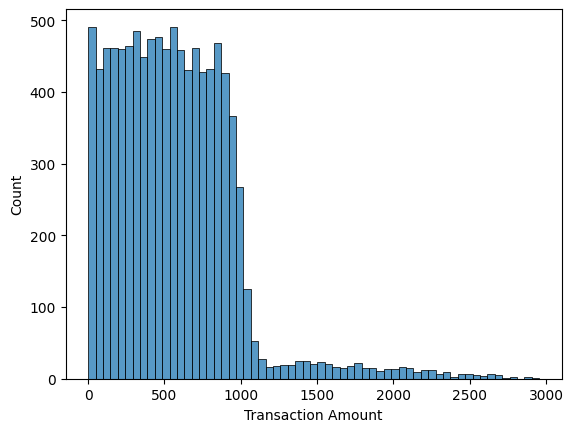

In [44]:
sns.histplot(x=data['Transaction Amount'])
plt.show()
#there seems to be an imbalance with transaction amount, with many more people with lower transaction amounts than high, decreases a lot after 1000

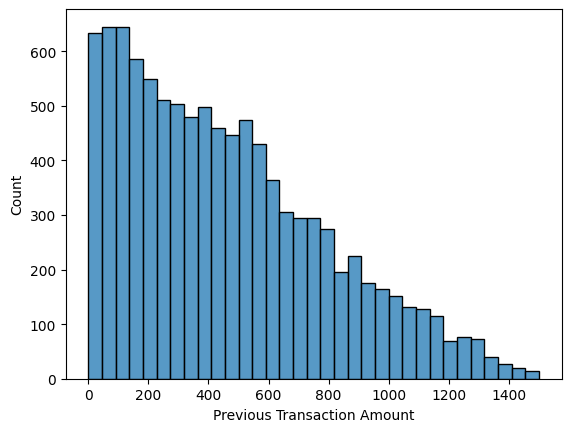

In [45]:
sns.histplot(x=data['Previous Transaction Amount'])
plt.show()
#more people have lower previous transaction amounts than high

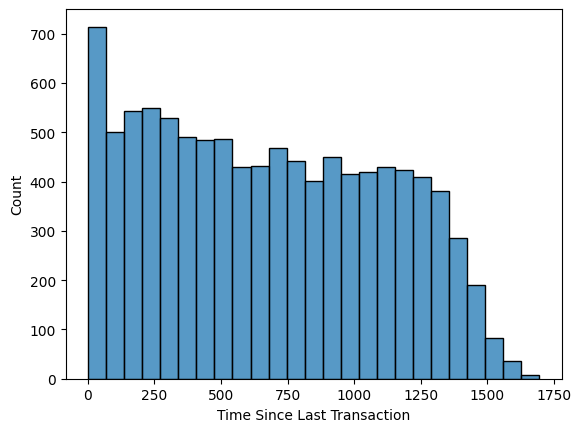

In [46]:
sns.histplot(x=data['Time Since Last Transaction'])
plt.show()
#this seems relatively balanced, with outliers on the tail ends

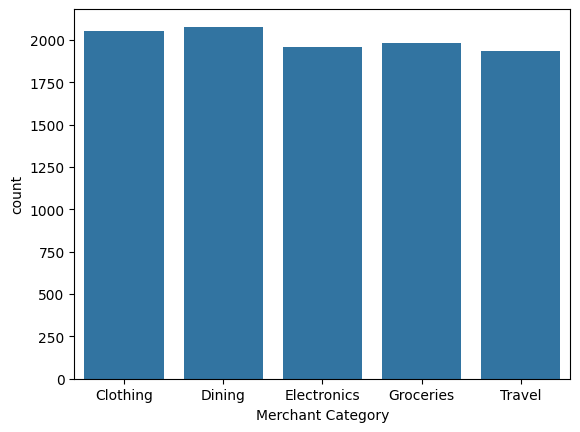

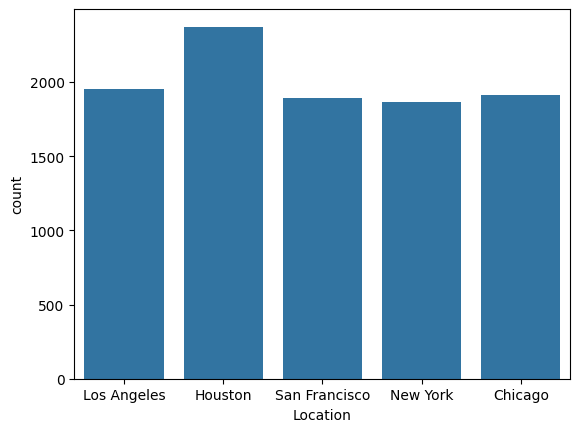

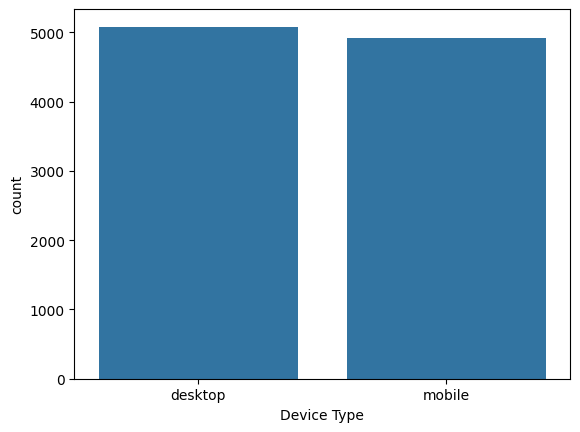

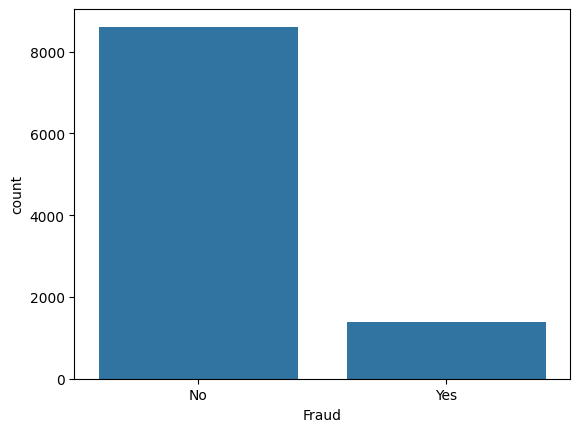

In [47]:
categorical_features = ['Merchant Category', 'Location', 'Device Type', 'Fraud']
for feature in categorical_features:
    sns.countplot(data=data, x=feature)
    plt.show()

    #main takeaways:
    #merchant category mostly balanced
    #location: more in Houstan
    #Device type mostly balanced
    #fraud: shows overall count: much more non fraudulent transactions than fraudulent - provides a baseline understanding of the extent of the problem

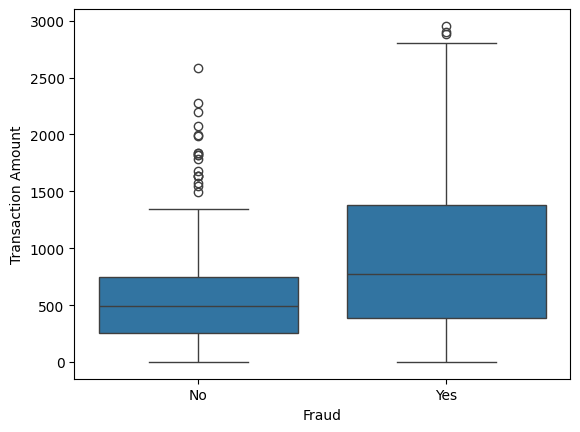

In [48]:
#Bivariate Visualizations:
#Visualizing relationships between features helps in understanding interactions and correlations. For instance, visualizing the relationship between transaction amount and fraud can show a clear trend.

sns.boxplot(data=data, x='Fraud', y='Transaction Amount')
plt.show()
#here shows that fraudulent transactions tend to be of a higher transaction amount in comparison to non fraudulent ones.

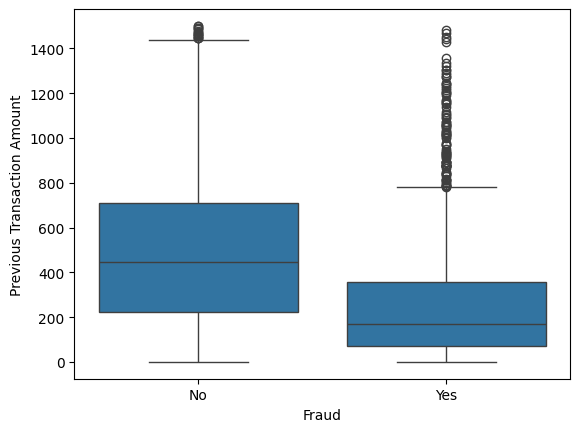

In [49]:
sns.boxplot(data=data, x='Fraud', y='Previous Transaction Amount')
plt.show()
#the previous transaction amount for non fraudulent instances is higher than for fraudulent

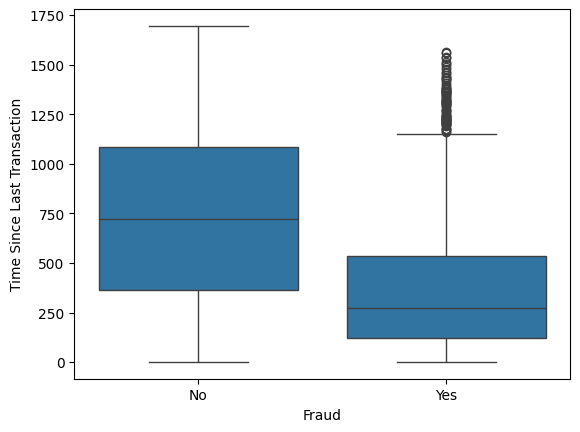

In [50]:
sns.boxplot(data=data, x='Fraud', y='Time Since Last Transaction')
plt.show()
#Non fraudulent transactions have on avg a longer time since the last transaction in comparison to fraudulent transactions

In [51]:
#Hypothesis:

#Based on the exploratory analysis, the hypothesis is that factors such as transaction amount, previous transaction amount, time since last transaction significantly influence transactions fraudulency.

In [52]:
#Feature Engineering

#Creating new features from the existing data to better represent the underlying patterns.

#Binary Encoding for Target Variable:
#The target variable Fraud was converted from categorical values ("Yes" and "No") to binary numerical values (1 for "Yes" and 0 for "No").

# Encoding categorical variables
data['Fraud'] = data['Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)

# Check column names
print(data.columns)

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')


In [53]:
#One-Hot Encoding for Categorical Variables:
#Categorical variables such as Merchant Category, Location, Device Type, were converted to numerical format using one-hot encoding.
#This creates binary columns for each category within the variable, allowing the model to process categorical data.
data = pd.get_dummies(data, columns=['Merchant Category', 'Location', 'Device Type'], drop_first=True)
# drop_first=True is used to avoid multicollinearity by dropping the first category of each feature.

In [54]:
#Dropping Unnecessary Columns:
#The Transaction ID and Customer ID columns were dropped as they are identifiers and do not contribute to the predictive power of the model.
data = data.drop(columns=['Transaction ID','Customer ID'])

In [55]:
# Split the data into features and target variable
#The data was split into features (X) and the target variable (y). The target variable Fraud was separated from the dataset.
X = data.drop(columns=['Fraud'])
y = data['Fraud']

In [56]:
#Data Transformation
#Feature Scaling:
#Numerical features were scaled to ensure they are on a similar scale.
#This is important for models like SVM and KNN which are sensitive to feature magnitudes.
#standardize the features by removing the mean and scaling to unit variance.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['Transaction Amount', 'Previous Transaction Amount', 'Time Since Last Transaction']
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [57]:
#Will test Logistic regression, Random Forest, SVM and KNN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [58]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[numerical_features], y, test_size=0.2, random_state=42)


In [59]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [60]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Model')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('ROC-AUC Score:', roc_auc_score(y_test, y_pred))
    print('---------------------------------------------')


Logistic Regression Model
Accuracy: 0.927
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1736
           1       0.95      0.47      0.63       264

    accuracy                           0.93      2000
   macro avg       0.94      0.73      0.79      2000
weighted avg       0.93      0.93      0.92      2000

Confusion Matrix:
 [[1730    6]
 [ 140  124]]
ROC-AUC Score: 0.7331203742494066
---------------------------------------------
Random Forest Model
Accuracy: 0.947
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1736
           1       0.93      0.64      0.76       264

    accuracy                           0.95      2000
   macro avg       0.94      0.82      0.87      2000
weighted avg       0.95      0.95      0.94      2000

Confusion Matrix:
 [[1724   12]
 [  94  170]]
ROC-AUC Score: 0.8185134757715403
--------------

In [61]:
#Evaluation metrics:

#Accuracy: Overall accuracy of the model.
#Precision, Recall, F1 Score: Evaluate the performance on positive and negative classes.
#Confusion Matrix: Provides insights into true positives, true negatives, false positives, and false negatives.
#ROC-AUC Score: Measures the ability of the model to distinguish between classes.

In [62]:
#Evaluating model performance
#based on the metrics described above, Random Forest Model will be chosen as the model to optimize

In [63]:
#Hyperparameter tuning the Random forest model

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best Params:', grid_search.best_params_)


Best Params: {'max_depth': 20, 'n_estimators': 100}


In [64]:
# Final model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print('Final Model Evaluation')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test, y_pred))

Final Model Evaluation
Accuracy: 0.9475
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1736
           1       0.93      0.65      0.77       264

    accuracy                           0.95      2000
   macro avg       0.94      0.82      0.87      2000
weighted avg       0.95      0.95      0.94      2000

Confusion Matrix:
 [[1724   12]
 [  93  171]]
ROC-AUC Score: 0.8204074151654795


In [65]:
# **** Explanation ****
#Data exploration findings:
#During the initial data exploration phase, examined various features such as Transaction Amount, Merchant Category, Location, Previous Transaction Amount, Time Since Last Transaction, and Device Type.
#We observed that certain factors like transaction amount, previous transaction amount, time since last transaction showed significant variations between fraudulent and non fraudulent transactions

#Initial Hypothesis
#Based on the exploratory analysis, the hypothesis is that transactions with higher transaction amounts, lower previous transaction amounts, and less time since last transaction are more likely to be fraudulent.

#Hypothesis Validation
#The hypothesis proved to be true, with higher transaction amounts being more likely to be fraudulent.
#Similarily, lower previous transaction amounts are corerelated with fraudulent purchases as well
#Fewer time since last transaction also proved to be a good predictory factor as fraudulent transactions happened more frequently soon after a past transaction had occurred.

#Approach for building and evaluating the model
# Data Preparation:
#We encoded the target variable Fraud as a binary value (1 for 'Yes' and 0 for 'No').
#Categorical variables such as Merchant category, Location, and Device Type were transformed using one-hot encoding to convert them into numerical format.
#The data was split into training and testing sets

#Model Development:
#We trained several machine learning models, including Logistic Regression, Random Forest, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN).
#Each model was evaluated using metrics such as accuracy, precision, recall, F1 score, and ROC-AUC to determine their performance

#Model Evaluation:
#Models were evaluated based on their performance on the test set, focusing on both overall accuracy and their ability to correctly identify fraudulent transactions.

# 1. Logistic Regression
# - Accuracy: 0.927
# - Precision: 0.93
# - Recall: 0.93
# - F1-Score: 0.92
# - ROC-AUC Score: 0.733

# 2. Random Forest Model
# - Accuracy: 0.947
# - Precision: 0.95
# - Recall: 0.95
# - F1-Score: 0.94
# - ROC-AUC Score: 0.816

# 3. SVM
# - Accuracy: 0.944
# - Precision: 0.94
# - Recall: 0.94
# - F1-Score: 0.94
# - ROC-AUC Score: 0.799

# 3. KNN
# - Accuracy: 0.9485
# - Precision: 0.95
# - Recall: 0.95
# - F1-Score: 0.94
# - ROC-AUC Score: 0.824

#Final Model Selection and Justification
#Selected Model:
#The Random Forest classifier and also KNN emerged as the best-performing models.
#The random Forest Model was selected to optimize further for the following reasons:
#Balanced Performance: The Random Forest model provided a good balance between precision and recall, making it effective in identifying both the number of fraudulent transactions that go undetected and also the number of legitimate transactions flagged as fraud
#Handling Imbalanced Data: Random Forest is robust to class imbalances and was able to handle the skewed distribution of the target variable effectively.
#Feature Importance: The model also provided insights into the importance of different features, helping us understand which factors are most influential in predicting fraud.
#The random forest model was selected as the final model and then hypertuned; we knew which parametres are the best by using Grid Search which tunes hyperparamtres automatically
#Here we select a "grid" of parameters, and for each possible combination, a model would be trained and scored on the testing data, which was seen in the final model evaulation.


#Business Application of the Model
#Usage in Business Process:
#Targeted Retention Strategies:
#The model identified transaction amount, previous transaction amount, time since last transaction as key predictors of Fraud.
#Customers with higher transaction amounts can be targeted with more fraud prevention initiatives compared to those who spend less.
#For example, a customer with a higher transaction amount may be flagged as potentially fraudulent and have the customer verify their identity in comparison to smaller transaction purchases.
#Since transactions with lower previous monetary amounts were more likely to be fraudulent, this can be taken in conjunction with the point earlier where the business should look out for accounts making a sudden large purchase especially if they have a history of small transaction amounts.
#For example, the company should target individuals who suddenly make large purchases with no prior history of this, to verification systems or locking their account
#The company should be more alert to active accounts who have recently made a purchase as last transaction time has an influence on fraud
#For example, the company can prioritize flagging active accounts which recently made purchases, and prompt them to prove their identity if they fall in the at risk categories mentioned here.

#By doing this, the company can minimize the number of fraudulent transactions that go undetected by using the model as a predictor
#As well as this, this will also reducing the number of legitimate transactions flagged as fraud as key indicators are prioritized as suspicious rather than being random.



